In [3]:
%cd Generative-AI


/content/Generative-AI


In [6]:
!mv /content/drive/MyDrive/Colab Notebooks/Gan.ipynb /content/Generative-AI/


mv: cannot stat '/content/drive/MyDrive/Colab': No such file or directory
mv: cannot stat 'Notebooks/Gan.ipynb': No such file or directory


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from torch.utils.tensorboard import SummaryWriter

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,in_features):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Linear(in_features,128),
        nn.LeakyReLU(0.01),
        nn.Linear(128,1),
        nn.Sigmoid(),
    )
  def forward(self,x):
    return self.disc(x)

In [ ]:
class Generator(nn.Module):
  def __init__(self,z_dim,img_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(z_dim,256),
        nn.LeakyReLU(0.01),
        nn.Linear(256,img_dim),
        nn.Tanh(),
    )
  def forward(self,x):
    return self.gen(x)

In [ ]:
# Hyperparameters
device  = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28*28*1
batch_size = 32
num_epochs = 50

disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim,image_dim).to(device)
fixed_noise = torch.randn((batch_size,z_dim)).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]
)

dataset = datasets.MNIST(root="dataset/",transform=transforms,download=True)
loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
opt_disc = optim.Adam(disc.parameters(),lr=lr)
opt_gen = optim.Adam(gen.parameters(),lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step = 0

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1


Epoch [0/50] Batch 0/1875                       Loss D: 0.6684, loss G: 0.7135
Epoch [1/50] Batch 0/1875                       Loss D: 0.5347, loss G: 0.9754
Epoch [2/50] Batch 0/1875                       Loss D: 0.6115, loss G: 0.9106
Epoch [3/50] Batch 0/1875                       Loss D: 0.2830, loss G: 1.7973
Epoch [4/50] Batch 0/1875                       Loss D: 0.3855, loss G: 1.4246
Epoch [5/50] Batch 0/1875                       Loss D: 1.0684, loss G: 0.5570
Epoch [6/50] Batch 0/1875                       Loss D: 0.8313, loss G: 0.6841
Epoch [7/50] Batch 0/1875                       Loss D: 0.4871, loss G: 1.0334
Epoch [8/50] Batch 0/1875                       Loss D: 0.7211, loss G: 0.9085
Epoch [9/50] Batch 0/1875                       Loss D: 0.5319, loss G: 1.2026
Epoch [10/50] Batch 0/1875                       Loss D: 0.6961, loss G: 1.2499
Epoch [11/50] Batch 0/1875                       Loss D: 0.8048, loss G: 0.6994
Epoch [12/50] Batch 0/1875                       L

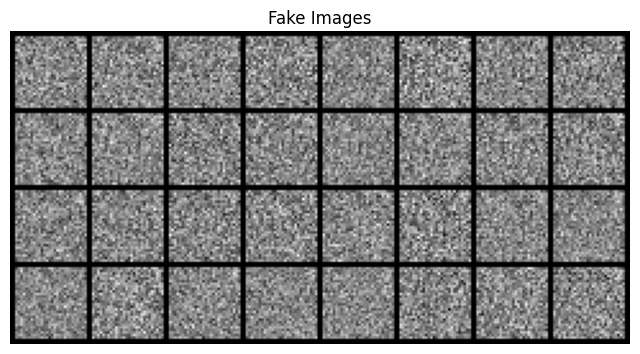

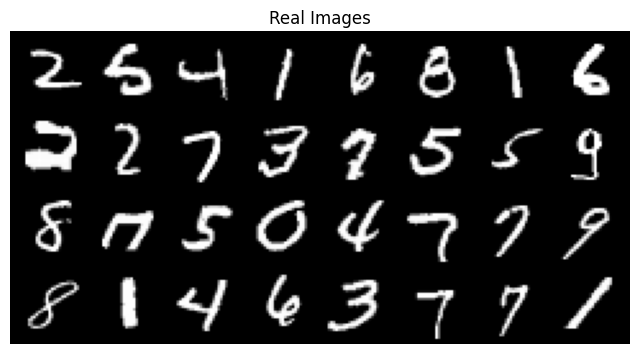

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


def display_images(images,title):
  images= images.cpu().detach()
  grid = make_grid(images,nrow=8,normalize=True)
  plt.figure(figsize=(8,8))
  plt.imshow(grid.permute(1,2,0))
  plt.axis('off')
  plt.title(title)
  plt.show()

# load trained generator
device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 64
gen.eval()

fixed_noise = torch.randn(batch_size, z_dim).to(device)
fake_images = gen(fixed_noise).reshape(-1,1,28,28)

real_images,_ = next(iter(loader))
real_images = real_images[:32]

display_images(fake_images,'Fake Images')
display_images(real_images,'Real Images')